# SI 618 - Homework #2: More Data Manipulation

In [511]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

### The total score for this assignment will be 100 points, consisting of:
- 10 pt: Overall quality of spelling, grammar, punctuation, etc. of written sentences. ([Guide](https://drive.google.com/file/d/1L0P7xJwjUGBvyb49mL3dw1Bt7hzRTiTl/view ))
- 10 pt: Codes are written in [PEP 8](https://www.python.org/dev/peps/pep-0008/) style.
- 80 pt: Homework questions. 

Version 2022.01.24.1.CT

# Background
You're a Data Science Consultant for an eCommerce retail company, they've asked you to analyze their sales database. Unfortunately, they did nothing to prepare or clean their data, only exporting their 3 database tables as JSON files. It's up to you to clean their data, analyze it and answer questions to help drive business value!

### The below files have been provided via the URLs shown:
- invoices.json https://github.com/umsi-data-science/data/raw/main/invoices.json
- items.json https://github.com/umsi-data-science/data/raw/main/items.json
- purchases.json https://github.com/umsi-data-science/data/raw/main/purchases.json

### They provided this data dictionary:

**InvoiceNo:** Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction.  
**StockCode:** Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.  
**Description:** Product (item) name. Nominal.   
**Quantity:** The quantities of each product (item) per transaction. Numeric.  
**InvoiceDate:** Invoice Date and time. Numeric, the day and time when each transaction was generated.  
**UnitPrice:** Unit price. Numeric, Product price per unit in sterling.  
**CustomerID:** Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.  
**Country:** Country name. Nominal, the name of the country where each customer resides.  

### A few notes from the company:
* If the InvoiceNo starts with the letter 'c', it indicates a cancellation. When conducting this analysis we only want to analyze invoices that were shipped. (ie. not canceled)
* The datasets should be able to be merged, each row in the invoice table corresponds to multiple rows in the purchases table.
* To find out the description or unit cost of an item in the purchase table, the StockCode should be used to match up the product in the items table. 
* They mentioned that they've been having a difficult time lately joining the items and purchases table, maybe there's something wrong with the columns?

# Answer the questions below.
- Write your Python code that can answer the following questions, 
- and explain **ALL** your answers in plain English. 
- you can use as many code and markdown cells as you need for each question (i.e. don't limit yourself to just one of each if you feel you need more).

In [286]:
MY_UNIQNAME = 'yjwoo'  # replace this with your uniqname

### <span style="color:magenta"> Q1. [5 points] Describe the dataset. </span>
1. Load the data. 
1. How many total invoices have been placed?
1. How many unique customers are there?
1. What is the total number of unique items?
1. Are there any columns with null values?
1. Thinking ahead, how do you think you would join the different tables? Please share 2-3 sentences about your approach.

## Load the data

In [287]:
df_invoice = pd.read_json("https://github.com/umsi-data-science/data/raw/main/invoices.json")
df_invoice.head()

,InvoiceNo,InvoiceDate,CustomerID,Country
0,536365,12/1/10 8:26,17850.0,United Kingdom
1,536366,12/1/10 8:28,17850.0,United Kingdom
2,536367,12/1/10 8:34,13047.0,United Kingdom
3,536368,12/1/10 8:34,13047.0,United Kingdom
4,536369,12/1/10 8:35,13047.0,United Kingdom


In [518]:
df_item = pd.read_json("https://github.com/umsi-data-science/data/raw/main/items.json")
df_item.head()

,StockCode,Description,UnitPrice
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55
1,71053,WHITE METAL LANTERN,3.39
2,84406B,CREAM CUPID HEARTS COAT HANGER,2.75
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.39
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.39


In [289]:
df_purchase = pd.read_json("https://github.com/umsi-data-science/data/raw/main/purchases.json")
df_purchase.head()

,InvoiceNo,StockCodeSC,Quantity
0,536365,SC85123A,6
1,536365,SC71053,6
2,536365,SC84406B,8
3,536365,SC84029G,6
4,536365,SC84029E,6


By the above codes, we have loaded invoice, purchase, item data.

## Invoice data

In [290]:
df_invoice.shape

(25943, 4)

Original invoice data has 25943 rows.

#### Invoice number

Since we are only interested in the invoices that are shipped, let's focus on the invoices that do not start with 'c'.

In [291]:
np.sum(df_invoice.InvoiceNo.str.startswith('C'))

3837

There is a total of 3837 rows that are related to the invoices not shipped.

In [292]:
df_invoice_shipped = df_invoice[df_invoice.InvoiceNo.str.startswith('C') == False]
df_invoice_shipped.shape

(22106, 4)

df_invoice_shipped has the invoices data that are shipped. df_invoice_shipped has a total of 22106 rows.

In [293]:
df_invoice_shipped[df_invoice_shipped.InvoiceNo.str.startswith('5') == False]

,InvoiceNo,InvoiceDate,CustomerID,Country
15466,A563185,8/12/11 14:50,NaN,United Kingdom
15467,A563186,8/12/11 14:51,NaN,United Kingdom
15468,A563187,8/12/11 14:52,NaN,United Kingdom


Three invoice numbers are different from general other invoice numbers in that they start with "A". Let's check if purchase data also has these three invoice numbers.

In [294]:
df_purchase[df_purchase.InvoiceNo.str.startswith('A')]

,InvoiceNo,StockCodeSC,Quantity
299982,A563185,SCB,1
299983,A563186,SCB,1
299984,A563187,SCB,1


Since purchase data has all the information related to these three abnormal invoice numbers, the analysis proceeds without deleting these three invoice numbers.

#### Customer ID

In [295]:
df_invoice_shipped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22106 entries, 0 to 25942
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    22106 non-null  object 
 1   InvoiceDate  22106 non-null  object 
 2   CustomerID   18566 non-null  float64
 3   Country      22106 non-null  object 
dtypes: float64(1), object(3)
memory usage: 863.5+ KB


In [296]:
np.sum(df_invoice_shipped.CustomerID.isnull())

3540

We can check that there are 3540 missing values in the "CumstomerID" column. <span style="color:magenta"> (Q1 - 4)

In [297]:
df_invoice_shipped[df_invoice_shipped.CustomerID.isnull()]

,InvoiceNo,InvoiceDate,CustomerID,Country
46,536414,12/1/10 11:52,NaN,United Kingdom
89,536544,12/1/10 14:32,NaN,United Kingdom
90,536545,12/1/10 14:32,NaN,United Kingdom
91,536546,12/1/10 14:33,NaN,United Kingdom
92,536547,12/1/10 14:33,NaN,United Kingdom
...,...,...,...,...
25859,581435,12/8/11 16:14,NaN,United Kingdom
25863,581439,12/8/11 16:30,NaN,United Kingdom
25911,581492,12/9/11 10:03,NaN,United Kingdom
25916,581497,12/9/11 10:23,NaN,United Kingdom


Even though invoice df_invoice_shipped has missing values in the "CustomerID" column, we can get other purchase information for each transaction by invoice numbers. Therefore, the analysis proceeds without deleting rows with a missing value in CustomerID.

#### Country

In [298]:
df_invoice_shipped.Country.value_counts()

United Kingdom    20161
Germany             457
France              393
EIRE                289
Belgium              98
                  ...  
Czech Republic        2
Saudi Arabia          1
Brazil                1
Lebanon               1
RSA                   1
Name: Country, Length: 38, dtype: int64

The above data shows how many rows exist for each country. We can check there is a total of 13 abnormal "Unspecified" rows in the "Country" column, which can be similar to a missing value.

In [299]:
df_invoice_shipped[df_invoice_shipped.Country == "Unspecified"]

,InvoiceNo,InvoiceDate,CustomerID,Country
7594,549687,4/11/11 13:29,12363.0,Unspecified
9350,552695,5/10/11 15:31,16320.0,Unspecified
10041,553857,5/19/11 13:30,NaN,Unspecified
12173,557499,6/20/11 15:25,16320.0,Unspecified
13339,559521,7/8/11 16:26,NaN,Unspecified
...,...,...,...,...
15911,563947,8/22/11 10:18,12363.0,Unspecified
15946,564051,8/22/11 13:32,14265.0,Unspecified
16621,565303,9/2/11 12:17,NaN,Unspecified
23151,576646,11/16/11 10:18,NaN,Unspecified


However, since we can also get other purchase information for each transaction by invoice numbers, the analysis proceeds without deleting "Unspecified" rows in the "Country" column.

#### Invoice date

In [300]:
np.sum(df_invoice_shipped.InvoiceDate.isnull())

0

There is no missing value in invoice date. <span style="color:magenta"> (Q1 - 4)

In principle, one invoice number should have one invoice date.

In [301]:
df_invoice_shipped = df_invoice_shipped.merge(df_invoice_shipped.groupby("InvoiceNo").count().InvoiceDate.reset_index().rename({"InvoiceDate" : "InvoiceDateCount"}, axis = 1), on = "InvoiceNo", how = "left")
df_invoice_shipped.head()

,InvoiceNo,InvoiceDate,CustomerID,Country,InvoiceDateCount
0,536365,12/1/10 8:26,17850.0,United Kingdom,1
1,536366,12/1/10 8:28,17850.0,United Kingdom,1
2,536367,12/1/10 8:34,13047.0,United Kingdom,1
3,536368,12/1/10 8:34,13047.0,United Kingdom,1
4,536369,12/1/10 8:35,13047.0,United Kingdom,1


In [302]:
df_invoice_shipped.InvoiceDateCount.sort_values()

0        1
14736    1
14735    1
14734    1
14733    1
        ..
6708     2
6863     2
6862     2
12573    2
5328     2
Name: InvoiceDateCount, Length: 22106, dtype: int64

From the above data, we can see that several invoice numbers have two different invoice dates.

In [303]:
pd.set_option('display.max_rows', df_invoice_shipped.shape[0]+1)

In [304]:
df_invoice_shipped.loc[df_invoice_shipped[df_invoice_shipped.InvoiceDateCount > 1].sort_values(by = ["InvoiceNo", "InvoiceDate", "CustomerID"]).index]

,InvoiceNo,InvoiceDate,CustomerID,Country,InvoiceDateCount
130,536591,12/1/10 16:57,14606.0,United Kingdom,2
131,536591,12/1/10 16:58,14606.0,United Kingdom,2
1789,540185,1/5/11 13:40,14653.0,United Kingdom,2
1790,540185,1/5/11 13:41,14653.0,United Kingdom,2
2374,541596,1/19/11 16:18,17602.0,United Kingdom,2
2375,541596,1/19/11 16:19,17602.0,United Kingdom,2
2389,541631,1/20/11 10:47,12637.0,France,2
2390,541631,1/20/11 10:48,12637.0,France,2
2454,541809,1/21/11 14:58,NaN,United Kingdom,2
2455,541809,1/21/11 14:59,NaN,United Kingdom,2


The invoice dates in each invoice number differed by only one minute each other, and other columns are all same. So I will only use the earlier of the two dates.

In [305]:
pd.set_option('display.max_rows', 10)

In [306]:
df_invoice_shipped

,InvoiceNo,InvoiceDate,CustomerID,Country,InvoiceDateCount
0,536365,12/1/10 8:26,17850.0,United Kingdom,1
1,536366,12/1/10 8:28,17850.0,United Kingdom,1
2,536367,12/1/10 8:34,13047.0,United Kingdom,1
3,536368,12/1/10 8:34,13047.0,United Kingdom,1
4,536369,12/1/10 8:35,13047.0,United Kingdom,1
...,...,...,...,...,...
22101,581583,12/9/11 12:23,13777.0,United Kingdom,1
22102,581584,12/9/11 12:25,13777.0,United Kingdom,1
22103,581585,12/9/11 12:31,15804.0,United Kingdom,1
22104,581586,12/9/11 12:49,13113.0,United Kingdom,1


In [307]:
df_invoice_shipped["partition_row_number"] = df_invoice_shipped.sort_values(by = ["InvoiceNo", "InvoiceDate"]).groupby("InvoiceNo").cumcount() + 1

In [308]:
df_invoice_shipped.loc[df_invoice_shipped[df_invoice_shipped.InvoiceDateCount > 1].sort_values(by = ["InvoiceNo", "InvoiceDate", "CustomerID"]).index]

,InvoiceNo,InvoiceDate,CustomerID,Country,InvoiceDateCount,partition_row_number
130,536591,12/1/10 16:57,14606.0,United Kingdom,2,1
131,536591,12/1/10 16:58,14606.0,United Kingdom,2,2
1789,540185,1/5/11 13:40,14653.0,United Kingdom,2,1
1790,540185,1/5/11 13:41,14653.0,United Kingdom,2,2
2374,541596,1/19/11 16:18,17602.0,United Kingdom,2,1
...,...,...,...,...,...,...
18395,574076,11/2/11 15:38,NaN,United Kingdom,2,2
19373,576057,11/13/11 15:05,15861.0,United Kingdom,2,1
19374,576057,11/13/11 15:06,15861.0,United Kingdom,2,2
20668,578548,11/24/11 15:02,17345.0,United Kingdom,2,1


In [309]:
df_invoice_shipped = df_invoice_shipped[df_invoice_shipped.partition_row_number == 1]
df_invoice_shipped.drop(["InvoiceDateCount", "partition_row_number"], axis = 1, inplace = True)
df_invoice_shipped.head()

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,InvoiceNo,InvoiceDate,CustomerID,Country
0,536365,12/1/10 8:26,17850.0,United Kingdom
1,536366,12/1/10 8:28,17850.0,United Kingdom
2,536367,12/1/10 8:34,13047.0,United Kingdom
3,536368,12/1/10 8:34,13047.0,United Kingdom
4,536369,12/1/10 8:35,13047.0,United Kingdom


In [310]:
df_invoice_shipped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22064 entries, 0 to 22105
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    22064 non-null  object 
 1   InvoiceDate  22064 non-null  object 
 2   CustomerID   18536 non-null  float64
 3   Country      22064 non-null  object 
dtypes: float64(1), object(3)
memory usage: 861.9+ KB


The column "InvoiceDate" is now object type, so I need to change this column to the DateTime type.

In [311]:
df_invoice_shipped["InvoiceDate"] = pd.to_datetime(df_invoice_shipped["InvoiceDate"])
df_invoice_shipped.head()

/var/folders/kb/9bgdwxjn0b751yc9w59v1ll00000gn/T/ipykernel_53930/964488366.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_invoice_shipped["InvoiceDate"] = pd.to_datetime(df_invoice_shipped["InvoiceDate"])


,InvoiceNo,InvoiceDate,CustomerID,Country
0,536365,2010-12-01 08:26:00,17850.0,United Kingdom
1,536366,2010-12-01 08:28:00,17850.0,United Kingdom
2,536367,2010-12-01 08:34:00,13047.0,United Kingdom
3,536368,2010-12-01 08:34:00,13047.0,United Kingdom
4,536369,2010-12-01 08:35:00,13047.0,United Kingdom


In [312]:
df_invoice_shipped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22064 entries, 0 to 22105
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    22064 non-null  object        
 1   InvoiceDate  22064 non-null  datetime64[ns]
 2   CustomerID   18536 non-null  float64       
 3   Country      22064 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 861.9+ KB


#### invoice data after preprocessing

In [313]:
df_invoice_shipped.shape

(22064, 4)

After completing all the preprocessing for the invoice data, the invoice data has a total of 22064 rows and 4 columns. 

In [314]:
len(df_invoice_shipped.InvoiceNo.unique())

22064

22064 unique invoices have been placed. <span style="color:magenta"> (Q1-2)

In [315]:
len(df_invoice_shipped.CustomerID.unique())

4340

There is a total of 4339 unique customers excluding missing values. <span style="color:magenta"> (Q1-3)

## Item data

In [316]:
df_item.head()

,StockCode,Description,UnitPrice
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55
1,71053,WHITE METAL LANTERN,3.39
2,84406B,CREAM CUPID HEARTS COAT HANGER,2.75
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.39
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.39


In [317]:
df_item.shape

(4070, 3)

Original item data has 4070 rows and 3 columns

#### stock code

In [318]:
df_item.loc[df_item.StockCode.sort_values().index]

,StockCode,Description,UnitPrice
31,10002,INFLATABLE POLITICAL GLOBE,0.85
3147,10080,GROOVY CACTUS INFLATABLE,0.85
1636,10120,DOGGY RUBBER,0.21
1635,10123C,HEARTS WRAPPING TAPE,0.65
3308,10123G,None,0.00
...,...,...,...
2843,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,17.02
2842,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,25.53
2774,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00,34.04
2815,gift_0001_50,Dotcomgiftshop Gift Voucher £50.00,42.55


In the above data, the stock code in the last row is abnormal "m". However, since this stock code has a valid description and unit price, it can be considered as the valid stock code.

In [319]:
np.sum(df_item.StockCode.isnull())

0

There is no missing value in the stock code column. <span style="color:magenta"> (Q1 - 4)

I think in principle there should be one description and price for each stock code.

In [320]:
df_item = df_item.merge(df_item.groupby("StockCode").count().reset_index().rename({"Description" : "description_count", "UnitPrice" : "unit_price_count"}, axis = 1), on = "StockCode", how = "left")
df_item

,StockCode,Description,UnitPrice,description_count,unit_price_count
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55,1,1
1,71053,WHITE METAL LANTERN,3.39,1,1
2,84406B,CREAM CUPID HEARTS COAT HANGER,2.75,1,1
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.39,1,1
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.39,1,1
...,...,...,...,...,...
4065,85179a,GREEN BITTY LIGHT CHAIN,2.46,1,1
4066,23617,SET 10 CARDS SWIRLY XMAS TREE 17104,2.91,1,1
4067,90214U,"LETTER ""U"" BLING KEY RING",0.29,1,1
4068,47591b,SCOTTIES CHILDRENS APRON,4.13,1,1


In [321]:
df_item.description_count.sort_values()

3303    0
2913    0
2399    0
2400    0
2401    0
       ..
1363    1
1364    1
1365    1
1352    1
4069    1
Name: description_count, Length: 4070, dtype: int64

In [322]:
df_item.unit_price_count.sort_values()

0       1
2705    1
2706    1
2707    1
2708    1
       ..
1362    1
1363    1
1364    1
1351    1
4069    1
Name: unit_price_count, Length: 4070, dtype: int64

By above two results, we can see that each stock code has at most one description and price value as I initially thought. So the stock code has nothing to deal with.

In [323]:
df_item.drop(["description_count", "unit_price_count"], axis = 1, inplace = True)

In [324]:
len(df_item.StockCode.unique())

4070

There is a total of 4070 unique items. <span style="color:magenta"> (Q1 - 5)

#### Unit price

In [325]:
df_item.loc[df_item.UnitPrice.sort_values().index]

,StockCode,Description,UnitPrice
3260,21614,None,0.00
3283,21274,None,0.00
3282,84845D,None,0.00
3280,84876C,None,0.00
3279,84875A,None,0.00
...,...,...,...
190,22827,RUSTIC SEVENTEEN DRAWER SIDEBOARD,165.00
2541,22826,LOVE SEAT ANTIQUE WHITE METAL,175.00
1591,22655,VINTAGE RED KITCHEN CABINET,295.00
952,DOT,DOTCOM POSTAGE,569.77


In [326]:
df_item[df_item.UnitPrice == 0].shape

(215, 3)

We can see that the minimum value of the unit price is 0 and the maximum value of the unit price is 11062.06. There is a total of 215 stock codes that have 0 unit prices.

In [327]:
df_item[df_item.UnitPrice == 0].Description.unique()

array([None, '?', 'check', 'FRENCH BLUE METAL DOOR SIGN 4',
       'CHILDS GARDEN TROWEL BLUE ', 'CHILDS GARDEN RAKE BLUE',
       'LUNCH BOX WITH CUTLERY FAIRY CAKES ',
       'TEATIME FUNKY FLOWER BACKPACK FOR 2', 'damages', 'Given away',
       'thrown away', 'throw away', "thrown away-can't sell.",
       "thrown away-can't sell", 'mailout ', 'mailout',
       'Thrown away-rusty', 'wet damaged', 'Damaged',
       'TRAVEL CARD WALLET DOTCOMGIFTSHOP', 'ebay', 'found', 'adjustment',
       'Found by jackie', 'Unsaleable, destroyed.'], dtype=object)

The list above is a collection of unique descriptions of stock code with a zero unit price. There are cases where the description is none, but I think it is difficult to interpret the case where the unit price is 0 as a missing value. So the unit price has nothing to deal with.

#### Description

In [328]:
df_item[df_item.Description.isnull()]

,StockCode,Description,UnitPrice
1041,21134,None,0.0
1042,22145,None,0.0
1043,37509,None,0.0
1047,85226A,None,0.0
1048,85044,None,0.0
...,...,...,...
3723,37477C,None,0.0
3839,35592T,None,0.0
3860,35598A,None,0.0
3958,23702,None,0.0


There are 176 missing values in the description column. <span style="color:magenta"> (Q1 - 5)

## Purchase data

In [329]:
df_purchase.head()

,InvoiceNo,StockCodeSC,Quantity
0,536365,SC85123A,6
1,536365,SC71053,6
2,536365,SC84406B,8
3,536365,SC84029G,6
4,536365,SC84029E,6


In [330]:
df_purchase.shape

(541909, 3)

Original purchase data has 541909 rows and 3 columns.

#### Invoice number

In [331]:
np.sum(df_purchase.InvoiceNo.isnull())

0

There is no missing value in the invoice number.  <span style="color:magenta"> (Q1 - 5)

Since we are not interested in the invoice numbers that were canceled, let's delete these rows.

In [332]:
df_purchase_shipped = df_purchase[df_purchase.InvoiceNo.str.startswith("C") == False]
df_purchase_shipped.head()

,InvoiceNo,StockCodeSC,Quantity
0,536365,SC85123A,6
1,536365,SC71053,6
2,536365,SC84406B,8
3,536365,SC84029G,6
4,536365,SC84029E,6


#### Stock code

In [333]:
np.sum(df_purchase_shipped.StockCodeSC.isnull())

0

There is no missing value in the stock code. <span style="color:magenta"> (Q1 - 5)

In the previous item data, stock code was used as the column name "StockCode". However, since "StockCodeSC" is used in the purchase data, let's unify it as "Stockcode".

In [334]:
np.sum(df_purchase_shipped.StockCodeSC.str.startswith("SC") == False)

0

All "StockcodeSC" values start with "SC", so I have to delete "SC" in front.

In [335]:
df_purchase_shipped["StockCode"] = df_purchase_shipped.StockCodeSC.str.split("SC").str[1]

/var/folders/kb/9bgdwxjn0b751yc9w59v1ll00000gn/T/ipykernel_53930/3471317207.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_purchase_shipped["StockCode"] = df_purchase_shipped.StockCodeSC.str.split("SC").str[1]


In [336]:
df_purchase_shipped.drop("StockCodeSC", inplace = True, axis = 1)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [337]:
df_purchase_shipped.head()

,InvoiceNo,Quantity,StockCode
0,536365,6,85123A
1,536365,6,71053
2,536365,8,84406B
3,536365,6,84029G
4,536365,6,84029E


#### Quantity

In [338]:
np.sum(df_purchase_shipped.Quantity.isnull())

0

There is no missing value in the quantity column. <span style="color:magenta"> (Q1 - 5)

In [339]:
df_purchase_shipped.Quantity.sort_values()

225530    -9600
225529    -9600
225528    -9058
115818    -5368
431381    -4830
          ...  
421632     4800
74614      5568
502122    12540
61619     74215
540421    80995
Name: Quantity, Length: 532621, dtype: int64

There are some minus values in the quantity column. Let's check these values.

In [340]:
df_purchase_shipped[df_purchase_shipped.Quantity <= 0]

,InvoiceNo,Quantity,StockCode
2406,536589,-10,21777
4347,536764,-38,84952C
7188,536996,-20,22712
7189,536997,-20,22028
7190,536998,-6,85067
...,...,...,...
535333,581210,-26,23395
535335,581212,-1050,22578
535336,581213,-30,22576
536908,581226,-338,23090


For now, I don't know for sure what the negative quantity means, so I'm going to leave it without deleting it for now. Later, when I need to use the quantity column, I will handle these negative values appropriately.

## Merge

First, I extracted only shipped records from the invoice data and will merge the other two tables based on this invoice data. When the purchase data is combined based on the invoice number of the invoice data, the information about which items and how many were traded in each transaction is combined. By combining the item data based on the stock code of the combined data, I can get the description and unit price information of each item traded. Because data can be combined only with the invoice number and stock code, first create data that has all information even if there are missing values in other columns. When performing subsequent analysis, the missing values will be appropriately handled according to the situation. 
<span style="color:magenta"> (Q1 - 6)

In [341]:
df_merged = df_invoice_shipped.merge(df_purchase_shipped, on = "InvoiceNo", how = "left").merge(df_item, on = "StockCode", how = "left")
df_merged

,InvoiceNo,InvoiceDate,CustomerID,Country,Quantity,StockCode,Description,UnitPrice
0,536365,2010-12-01 08:26:00,17850.0,United Kingdom,6,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55
1,536365,2010-12-01 08:26:00,17850.0,United Kingdom,6,71053,WHITE METAL LANTERN,3.39
2,536365,2010-12-01 08:26:00,17850.0,United Kingdom,8,84406B,CREAM CUPID HEARTS COAT HANGER,2.75
3,536365,2010-12-01 08:26:00,17850.0,United Kingdom,6,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.39
4,536365,2010-12-01 08:26:00,17850.0,United Kingdom,6,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.39
...,...,...,...,...,...,...,...,...
532616,581587,2011-12-09 12:50:00,12680.0,France,12,22613,PACK OF 20 SPACEBOY NAPKINS,1.66
532617,581587,2011-12-09 12:50:00,12680.0,France,6,22899,CHILDREN'S APRON DOLLY GIRL,2.10
532618,581587,2011-12-09 12:50:00,12680.0,France,4,23254,CHILDRENS CUTLERY DOLLY GIRL,4.15
532619,581587,2011-12-09 12:50:00,12680.0,France,4,23255,CHILDRENS CUTLERY CIRCUS PARADE,4.15


In [342]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 532621 entries, 0 to 532620
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    532621 non-null  object        
 1   InvoiceDate  532621 non-null  datetime64[ns]
 2   CustomerID   397924 non-null  float64       
 3   Country      532621 non-null  object        
 4   Quantity     532621 non-null  int64         
 5   StockCode    532621 non-null  object        
 6   Description  531204 non-null  object        
 7   UnitPrice    532621 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.6+ MB


Since customer ID means a separate entity rather than a mathematical number, the object type is more appropriate than float. So I will change the customer id to object type.

In [343]:
df_merged = df_merged.astype({"CustomerID" : object})
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 532621 entries, 0 to 532620
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    532621 non-null  object        
 1   InvoiceDate  532621 non-null  datetime64[ns]
 2   CustomerID   397924 non-null  object        
 3   Country      532621 non-null  object        
 4   Quantity     532621 non-null  int64         
 5   StockCode    532621 non-null  object        
 6   Description  531204 non-null  object        
 7   UnitPrice    532621 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 36.6+ MB


In [344]:
df_merged = df_merged[["InvoiceNo", "InvoiceDate", "CustomerID", "Country", "StockCode", "Description", "UnitPrice", "Quantity"]]
df_merged

,InvoiceNo,InvoiceDate,CustomerID,Country,StockCode,Description,UnitPrice,Quantity
0,536365,2010-12-01 08:26:00,17850.0,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55,6
1,536365,2010-12-01 08:26:00,17850.0,United Kingdom,71053,WHITE METAL LANTERN,3.39,6
2,536365,2010-12-01 08:26:00,17850.0,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,2.75,8
3,536365,2010-12-01 08:26:00,17850.0,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.39,6
4,536365,2010-12-01 08:26:00,17850.0,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.39,6
...,...,...,...,...,...,...,...,...
532616,581587,2011-12-09 12:50:00,12680.0,France,22613,PACK OF 20 SPACEBOY NAPKINS,1.66,12
532617,581587,2011-12-09 12:50:00,12680.0,France,22899,CHILDREN'S APRON DOLLY GIRL,2.10,6
532618,581587,2011-12-09 12:50:00,12680.0,France,23254,CHILDRENS CUTLERY DOLLY GIRL,4.15,4
532619,581587,2011-12-09 12:50:00,12680.0,France,23255,CHILDRENS CUTLERY CIRCUS PARADE,4.15,4


### <span style="color:magenta"> Q2. [10 points] Invoice Analysis </span>
1. For each customer calculate how many total invoices they have placed. List the top 10 customers who have placed an invoice in descending order.
2. Perform a similar calculation but instead of the number of invoices, calculate the total quantity of items ordered for each customer. List the top 10 customers in descending order.
3. Compare the top 10 customers, does it appear that the more invoices a customer have, the greater the total quantity of items? Explain your reasoning.

_Hint: For 2.2, you may need to join two datasets together to answer the question._

<span style="color:magenta"> (Q2 - 1)

In [345]:
pd.DataFrame(df_merged.groupby("CustomerID").InvoiceNo.nunique().sort_values(ascending = False).head(10).reset_index().rename({"InvoiceNo" : "total_invoice_number"}, axis = 1)) \
    .merge(df_merged.groupby("CustomerID").InvoiceDate.min().reset_index().rename({"InvoiceDate" : "min_invoice_date"}, axis = 1), on = "CustomerID", how = "left") \
    .merge(df_merged.groupby("CustomerID").InvoiceDate.max().reset_index().rename({"InvoiceDate" : "max_invoice_date"}, axis = 1), on = "CustomerID", how = "left")

,CustomerID,total_invoice_number,min_invoice_date,max_invoice_date
0,12748.0,210,2010-12-01 12:48:00,2011-12-09 12:20:00
1,14911.0,201,2010-12-01 14:05:00,2011-12-08 15:54:00
2,17841.0,124,2010-12-01 14:41:00,2011-12-08 12:07:00
3,13089.0,97,2010-12-05 10:27:00,2011-12-07 09:02:00
4,14606.0,93,2010-12-01 16:57:00,2011-12-08 19:28:00
5,15311.0,91,2010-12-01 09:41:00,2011-12-09 12:00:00
6,12971.0,86,2010-12-02 16:42:00,2011-12-06 12:20:00
7,14646.0,74,2010-12-20 10:09:00,2011-12-08 12:12:00
8,16029.0,63,2010-12-01 09:57:00,2011-11-01 10:27:00
9,13408.0,62,2010-12-01 10:39:00,2011-12-08 09:05:00


The above customers are the top 10 customers who have placed the invoice in descending order. The largest number of invoices is 210, which is more than three times the number of 62 invoices in the 10th place. All of the top 10 users have placed orders for the same period of about 1 year. 

 <span style="color:magenta"> (Q2 - 2)

In [346]:
pd.DataFrame(df_merged.groupby("CustomerID").Quantity.sum().sort_values(ascending = False).reset_index().rename({"Quantity" : "total_quantity"}, axis = 1)).head(10) \
    .merge(df_merged.groupby("CustomerID").InvoiceDate.min().reset_index().rename({"InvoiceDate" : "min_invoice_date"}, axis = 1), on = "CustomerID", how = "left") \
    .merge(df_merged.groupby("CustomerID").InvoiceDate.max().reset_index().rename({"InvoiceDate" : "max_invoice_date"}, axis = 1), on = "CustomerID", how = "left")

,CustomerID,total_quantity,min_invoice_date,max_invoice_date
0,14646.0,197491,2010-12-20 10:09:00,2011-12-08 12:12:00
1,16446.0,80997,2011-05-18 09:52:00,2011-12-09 09:15:00
2,14911.0,80515,2010-12-01 14:05:00,2011-12-08 15:54:00
3,12415.0,77670,2011-01-06 11:12:00,2011-11-15 14:22:00
4,12346.0,74215,2011-01-18 10:01:00,2011-01-18 10:01:00
5,17450.0,69993,2010-12-07 09:23:00,2011-12-01 13:29:00
6,17511.0,64549,2010-12-01 10:19:00,2011-12-07 10:12:00
7,18102.0,64124,2010-12-07 16:42:00,2011-12-09 11:50:00
8,13694.0,63312,2010-12-01 12:12:00,2011-12-06 09:32:00
9,14298.0,58343,2010-12-14 12:59:00,2011-12-01 13:12:00


The table above shows the top 10 users with the highest total quantity. The largest total quantity is about 200,000, which is more than three times that of about 60,000 in the 10th place. When looking at the period of ordering as well, customer 12346 ordered 70,000 quantities a day. That is, customer 14646 has the largest total quantity without considering the period, and 12346 has the largest total quantity considering the period.

 <span style="color:magenta"> (Q2 - 3)

Let's consider the number of invoices and the total quantity together.

In [347]:
df_total_invoice_quantity = pd.DataFrame(df_merged.groupby("CustomerID").InvoiceNo.nunique().reset_index().rename({"InvoiceNo" : "total_invoice_number"}, axis = 1)) \
                                .merge(df_merged.groupby("CustomerID").Quantity.sum().reset_index().rename({"Quantity" : "total_quantity"}, axis = 1))

In [348]:
df_total_invoice_quantity.sort_values("total_invoice_number", ascending = False).head(10)

,CustomerID,total_invoice_number,total_quantity
326,12748.0,210,25748
1880,14911.0,201,80515
4011,17841.0,124,23071
562,13089.0,97,31070
1662,14606.0,93,6224
2177,15311.0,91,38194
481,12971.0,86,9289
1690,14646.0,74,197491
2703,16029.0,63,40208
796,13408.0,62,16232


In [349]:
df_total_invoice_quantity[["total_invoice_number","total_quantity"]].corr()

,total_invoice_number,total_quantity
total_invoice_number,1.000000,0.558005
total_quantity,0.558005,1.000000


First, if you check the correlation between the total invoice number and total quantity for all customers, it is about 0.5. The correlation coefficient is a statistic that indicates how linear two variables are and has a value between -1 and 1. A positive value indicates a positive linear relationship, and a negative value indicates a negative linear relationship. The closer the absolute value is to 1, the stronger the linear relationship is. Since the correlation is about 0.5, it can be seen that the total invoice number and total quantity show a positive linear relationship to some extent.

In [350]:
df_total_invoice_quantity[["total_invoice_number","total_quantity"]].sort_values("total_invoice_number", ascending = False).head(10).corr()

,total_invoice_number,total_quantity
total_invoice_number,1.000000,-0.038673
total_quantity,-0.038673,1.000000


However, when only the top 10 people based on the invoice number were analyzed, it can be seen that the correlation between the total invoice number and the total quantity is rather low at -0.03.

<AxesSubplot:xlabel='total_invoice_number', ylabel='total_quantity'>

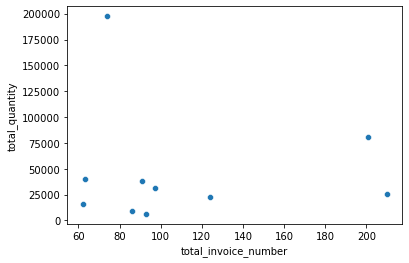

In [351]:
sns.scatterplot(x = "total_invoice_number", y = "total_quantity", data = df_total_invoice_quantity[["total_invoice_number","total_quantity"]].sort_values("total_invoice_number", ascending = False).head(10),)

Even if you look at the total invoice number and total quantity of the top 10 people as a plot, you can see that there is almost no linear relationship between the two variables.

### <span style="color:magenta"> Q3. [10 points] Item Analysis </span>
1. What is the average item-unit price? 
1. What % of items are under $25?
1. Generate a histogram of the unit prices. Select reasonable min/max values for the x-axis. Why did you pick those values? What do you notice about the histogram? 

 <span style="color:magenta"> (Q3 - 1), (Q3 - 3)

In [352]:
df_item.UnitPrice.mean()

6.905277886977952

In simple calculations, the average unit price of an item is about 7 sterling.

In [353]:
df_item[df_item.UnitPrice == 0].shape

(215, 3)

In [354]:
df_item_positive_price = df_item[df_item.UnitPrice > 0]
df_item_positive_price.UnitPrice.mean()

7.290397146562974

However, about 5% of the items in the item data have a unit price of 0. So, if you exclude items with a unit price of 0, the average unit price is 7.2 sterling.

In [355]:
df_item_positive_price.describe()

,UnitPrice
count,3855.000000
mean,7.290397
std,178.548626
min,0.001000
25%,1.250000
50%,2.510000
75%,4.950000
max,11062.060000


Also, since the average is greatly affected by outliers, it is necessary to check whether there are outliers when calculating the average. Looking at the table above, about 75% of items are lower than 5 sterling, but the average price we found above was 7.2 sterling. This is because there is an extreme value in the price, such as the max value of 11062.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='UnitPrice', ylabel='Density'>

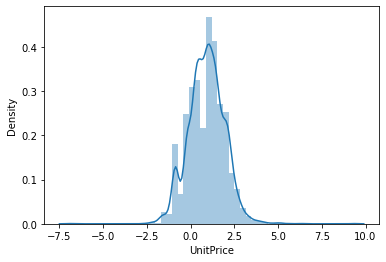

In [356]:
sns.distplot(np.log(df_item_positive_price.UnitPrice))

If you log-transform the unit price, you can confirm that it roughly follows a normal distribution. Therefore, let's reduce the influence of outliers by using only about 95% of the data within 2 standard deviations from the average in the log unit price.

In [357]:
lower_bound = np.log(df_item_positive_price.UnitPrice).describe()[1] - (2 * np.log(df_item_positive_price.UnitPrice).describe()[2])
lower_bound

-1.1411714381940192

In [358]:
upper_bound = np.log(df_item_positive_price.UnitPrice).describe()[1] + (2 * np.log(df_item_positive_price.UnitPrice).describe()[2])
upper_bound

2.9566302011417886

In [359]:
df_item_positive_price_except_outlier = df_item_positive_price[(np.log(df_item_positive_price.UnitPrice) > lower_bound) & (np.log(df_item_positive_price.UnitPrice) < upper_bound)]
df_item_positive_price_except_outlier.describe()

,UnitPrice
count,3716.000000
mean,3.580312
std,3.244735
min,0.320000
25%,1.250000
50%,2.510000
75%,4.250000
max,19.130000


/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='UnitPrice', ylabel='Density'>

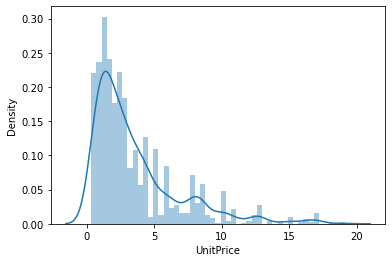

In [360]:
sns.distplot(df_item_positive_price_except_outlier.UnitPrice)

When looking at only 95% of data excluding outliers, the minimum value of unit price is 0.3 sterling and the maximum value is 19 sterling, which is somewhat reasonable. The average item-unit price is 3.58 sterling with this reduced data.

 <span style="color:magenta"> (Q3 - 2)

To find items that are under 25$, we have to convert our sterling unit price to dollar unit price. I will apply the exchange rate between sterling and dollar as 1:1.3.

In [361]:
df_item["unit_price_dollar"] = df_item.UnitPrice * 1.13
df_item

,StockCode,Description,UnitPrice,unit_price_dollar
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55,2.8815
1,71053,WHITE METAL LANTERN,3.39,3.8307
2,84406B,CREAM CUPID HEARTS COAT HANGER,2.75,3.1075
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.39,3.8307
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.39,3.8307
...,...,...,...,...
4065,85179a,GREEN BITTY LIGHT CHAIN,2.46,2.7798
4066,23617,SET 10 CARDS SWIRLY XMAS TREE 17104,2.91,3.2883
4067,90214U,"LETTER ""U"" BLING KEY RING",0.29,0.3277
4068,47591b,SCOTTIES CHILDRENS APRON,4.13,4.6669


In [362]:
np.sum(df_item.unit_price_dollar < 25) / len(df_item.unit_price_dollar < 25)

0.9867321867321868

Including zero-price items, about 98.6% of items are under $25. 

In [363]:
np.sum(df_item.loc[df_item_positive_price.index].unit_price_dollar < 25) / len(df_item.loc[df_item_positive_price.index].unit_price_dollar < 25)

0.9859922178988327

Excluding zero-price items, about 93.3% of items are under $25.

In [364]:
np.sum(df_item.loc[df_item_positive_price_except_outlier.index].unit_price_dollar < 25) / len(df_item.loc[df_item_positive_price_except_outlier.index].unit_price_dollar < 25)

1.0

Excluding all outliers as above, all items are under $25.

### <span style="color:magenta"> Q4. [25 points] Order Trends </span>
1. What are the top 10 most ordered items? Describe them. Do you see any trends?  
1. What are the top 5 invoices that generated the most revenue? (Revenue is calculated by "marking up" the unit price by 25%.) 
1. Do the top 5 invoices contain any of the top 10 most ordered items?

_Hint: When calculating the revenue we suggest adding a new column on the dataframe._

 <span style="color:magenta"> (Q4 - 1)

There can be several different ways to measure the most ordered items. If it is measured based on quantity, rank can be affected in cases where a particular item is traded a lot in one transaction. So I will measure most ordered items by invoice count. Also, since we only need to measure when items are clearly ordered, we will exclude cases where quantity is negative.

In [365]:
df_merged_positive_quantity = df_merged[df_merged.Quantity > 0]

In [366]:
most_ordered_items = df_merged_positive_quantity.groupby("StockCode").InvoiceNo.nunique().sort_values(ascending = False).head(10).reset_index().rename({"InvoiceNo" : "invoice_count"}, axis = 1) \
                     .merge(df_item[["StockCode", "Description"]], on = "StockCode", how = "left")
most_ordered_items

,StockCode,invoice_count,Description
0,85123A,2203,WHITE HANGING HEART T-LIGHT HOLDER
1,85099B,2092,JUMBO BAG RED RETROSPOT
2,22423,1989,REGENCY CAKESTAND 3 TIER
3,47566,1686,PARTY BUNTING
4,20725,1565,LUNCH BAG RED RETROSPOT
5,84879,1455,ASSORTED COLOUR BIRD ORNAMENT
6,22197,1392,SMALL POPCORN HOLDER
7,22720,1387,SET OF 3 CAKE TINS PANTRY DESIGN
8,21212,1320,PACK OF 72 RETROSPOT CAKE CASES
9,22383,1285,LUNCH BAG SUKI DESIGN


The above table shows the top 10 most ordered items. Overall, party-related items seem to occupy the upper ranks. The 3rd, 8th, and 9th places were cake-related items, and there were a total of 4700 invoices. The 1st, 4th, 6th, and 7th places were party-related decorations, and there were a total of 6700 invoices. The 2nd, 5th, and 10th places were bag types, and there were a total of 4900 invoices. 

<span style="color:magenta"> (Q4 - 2)

Revenue is calculated by "marking up" the unit price by 25%. So, let's make a new revenue column calculated by unit price * 1.25 * quantity.

In [367]:
df_merged_positive_quantity["revenue"] = df_merged_positive_quantity.UnitPrice * 1.25 * df_merged_positive_quantity.Quantity
df_merged_positive_quantity

/var/folders/kb/9bgdwxjn0b751yc9w59v1ll00000gn/T/ipykernel_53930/1210467572.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_positive_quantity["revenue"] = df_merged_positive_quantity.UnitPrice * 1.25 * df_merged_positive_quantity.Quantity


,InvoiceNo,InvoiceDate,CustomerID,Country,StockCode,Description,UnitPrice,Quantity,revenue
0,536365,2010-12-01 08:26:00,17850.0,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55,6,19.1250
1,536365,2010-12-01 08:26:00,17850.0,United Kingdom,71053,WHITE METAL LANTERN,3.39,6,25.4250
2,536365,2010-12-01 08:26:00,17850.0,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,2.75,8,27.5000
3,536365,2010-12-01 08:26:00,17850.0,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.39,6,25.4250
4,536365,2010-12-01 08:26:00,17850.0,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.39,6,25.4250
...,...,...,...,...,...,...,...,...,...
532616,581587,2011-12-09 12:50:00,12680.0,France,22613,PACK OF 20 SPACEBOY NAPKINS,1.66,12,24.9000
532617,581587,2011-12-09 12:50:00,12680.0,France,22899,CHILDREN'S APRON DOLLY GIRL,2.10,6,15.7500
532618,581587,2011-12-09 12:50:00,12680.0,France,23254,CHILDRENS CUTLERY DOLLY GIRL,4.15,4,20.7500
532619,581587,2011-12-09 12:50:00,12680.0,France,23255,CHILDRENS CUTLERY CIRCUS PARADE,4.15,4,20.7500


In [368]:
invoice_top_revenue = np.round(df_merged_positive_quantity.groupby("InvoiceNo").sum()[["revenue", "Quantity"]].sort_values("revenue", ascending = False).head(5)) \
                          .merge(df_merged_positive_quantity.groupby("InvoiceNo").nunique().StockCode, on = "InvoiceNo", how = "left") \
                          .merge(df_invoice_shipped[["InvoiceNo", "Country", "CustomerID", "InvoiceDate"]], on = "InvoiceNo", how = "left") \
                          .rename({"revenue" : "total_revenue", "Quantity" : "total_quantity", "StockCode" : "unique_stockcode_count"}, axis = 1)
invoice_top_revenue

,InvoiceNo,total_revenue,total_quantity,unique_stockcode_count,Country,CustomerID,InvoiceDate
0,547966,712212.0,1000,1,United Kingdom,NaN,2011-03-28 15:49:00
1,581483,210587.0,80995,1,United Kingdom,16446.0,2011-12-09 09:15:00
2,541431,96480.0,74215,1,United Kingdom,12346.0,2011-01-18 10:01:00
3,556255,37305.0,3600,12,United Kingdom,18102.0,2011-06-09 17:27:00
4,556917,34546.0,15049,138,Australia,12415.0,2011-06-15 13:37:00


The above table shows the top 5 invoices that generated the most revenue in sterling. 1st invoice generated revenue of 710,000 sterling, which is three times higher than the second invoice's revenue of 210,000 sterling. The trades that yielded the most revenue were only 1000 quantities of only one type. Compared to other invoices that traded 3,000, 10,000, 70,000, and 80,000 quantities, it can be seen that the largest profit was made with a very small quantity. Of the total of 5 invoices, only 1 was ordered from Australia and the remaining 4 were all ordered from the United Kingdom. And all 4 invoices were made in the first half of 2011, and only one invoice was made at the end of 2011. 

 <span style="color:magenta"> (Q4 - 3) Do the top 5 invoices contain any of the top 10 most ordered items?

In [369]:
most_ordered_items["is_most_ordered"] = 1

In [370]:
invoice_top_revenue_with_item = df_merged_positive_quantity[["InvoiceNo","StockCode"]].merge(invoice_top_revenue["InvoiceNo"], on = "InvoiceNo", how = "inner") \
                                    .merge(most_ordered_items[["StockCode", "Description", "is_most_ordered"]], on = "StockCode", how = "left").fillna(0)
invoice_top_revenue_with_item

,InvoiceNo,StockCode,Description,is_most_ordered
0,541431,23166,0,0.0
1,547966,DOT,0,0.0
2,556255,48138,0,0.0
3,556255,48173C,0,0.0
4,556255,48188,0,0.0
...,...,...,...,...
148,556917,22364,0,0.0
149,556917,22363,0,0.0
150,556917,21115,0,0.0
151,556917,22308,0,0.0


In [371]:
invoice_top_revenue_with_item[invoice_top_revenue_with_item.is_most_ordered == 1] 

,InvoiceNo,StockCode,Description,is_most_ordered
61,556917,20725,LUNCH BAG RED RETROSPOT,1.0
89,556917,85099B,JUMBO BAG RED RETROSPOT,1.0
100,556917,22423,REGENCY CAKESTAND 3 TIER,1.0
107,556917,21212,PACK OF 72 RETROSPOT CAKE CASES,1.0
110,556917,22720,SET OF 3 CAKE TINS PANTRY DESIGN,1.0


is_most_ordered column has a value of 1 if each item in each invoice is the top 10 most ordered items. Looking at the table above, only the "556917" invoice of the top 5 invoices contains 5 items from the top 10 most ordered items. This invoice contains all cake-related items and two bag-related items of the top 10 most ordered items.

### <span style="color:magenta"> Q5. [30 points] Customer Analysis </span>
1. Classify customers into segments based on the total revenue they have generated for the company.
 * low value: less than \$1500  
 * medium value: between 1500 and 8000 dollars
 * high value: greater than \$8000
1. How many customers are in each segment? 
1. Using the pivot table function, create a table that displays the average order quantity of each stock code for a given segment.
1. Are the items with the highest average order quantity generally the same across segments? Explain your reasoning. 
1. Choose three items and discuss any trends/differences you notice across the three segments.

_Hint: When calculating the segment, we suggest constructing a new dataframe as an intermediary step with the columns: CustomerID, Revenue, Segment._

Since the customer segments are divided based on revenue calculated in dollars, let's convert revenue into dollars.

In [372]:
df_merged_positive_quantity["revenue_dollar"] = df_merged_positive_quantity.revenue * 1.3
df_merged_positive_quantity.head()

/var/folders/kb/9bgdwxjn0b751yc9w59v1ll00000gn/T/ipykernel_53930/3486501612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_positive_quantity["revenue_dollar"] = df_merged_positive_quantity.revenue * 1.3


,InvoiceNo,InvoiceDate,CustomerID,Country,StockCode,Description,UnitPrice,Quantity,revenue,revenue_dollar
0,536365,2010-12-01 08:26:00,17850.0,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55,6,19.125,24.8625
1,536365,2010-12-01 08:26:00,17850.0,United Kingdom,71053,WHITE METAL LANTERN,3.39,6,25.425,33.0525
2,536365,2010-12-01 08:26:00,17850.0,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,2.75,8,27.500,35.7500
3,536365,2010-12-01 08:26:00,17850.0,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.39,6,25.425,33.0525
4,536365,2010-12-01 08:26:00,17850.0,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.39,6,25.425,33.0525


In [373]:
customer_revenue = df_merged_positive_quantity.groupby("CustomerID").sum().revenue_dollar.reset_index().rename({"revenue_dollar" : "total_revenue_dollar"}, axis = 1)
customer_revenue

,CustomerID,total_revenue_dollar
0,12346.0,125423.35000
1,12347.0,8837.46500
2,12348.0,2909.01000
3,12349.0,3131.31000
4,12350.0,663.06500
...,...,...
4334,18280.0,412.19750
4335,18281.0,109.65500
4336,18282.0,377.60125
4337,18283.0,3451.56500


In [374]:
low_segment_mask = customer_revenue.total_revenue_dollar < 1500
medium_segment_mask = (customer_revenue.total_revenue_dollar >= 1500) & (customer_revenue.total_revenue_dollar < 8000)
high_segment_mask = customer_revenue.total_revenue_dollar >= 8000

In [375]:
customer_revenue.loc[low_segment_mask, "revenue_segment"] = "low"
customer_revenue.loc[medium_segment_mask, "revenue_segment"] = "medium"
customer_revenue.loc[high_segment_mask, "revenue_segment"] = "high"

In [376]:
customer_revenue

,CustomerID,total_revenue_dollar,revenue_segment
0,12346.0,125423.35000,high
1,12347.0,8837.46500,high
2,12348.0,2909.01000,medium
3,12349.0,3131.31000,medium
4,12350.0,663.06500,low
...,...,...,...
4334,18280.0,412.19750,low
4335,18281.0,109.65500,low
4336,18282.0,377.60125,low
4337,18283.0,3451.56500,medium


Based on the criteria above, 3 segments(high, medium, and low) were created.

<span style="color:magenta"> (Q5 - 1) How many customers are in each segment?

In [377]:
customer_revenue.groupby("revenue_segment").count().CustomerID.reset_index() \
    .merge(round(customer_revenue.groupby("revenue_segment").count().CustomerID / np.sum(customer_revenue.groupby("revenue_segment").count().CustomerID) * 100, 1), on = "revenue_segment", how = "left") \
    .rename({"CustomerID_x" : "total_customer_count", "CustomerID_y" : "total_customer_count_ratio"}, axis = 1) \
    .loc[[0, 2, 1]]

,revenue_segment,total_customer_count,total_customer_count_ratio
0,high,356,8.2
2,medium,1656,38.2
1,low,2327,53.6


There are 2327 customers in the low segment which is about 54% of the total customers. About 38% of total customers, or 1656, belong to the medium group, and about 8%, or 356 customers, belong to the high group.

<span style="color:magenta"> (Q5 - 2) Using the pivot table function, create a table that displays the average order quantity of each stock code for a given segment.

In [378]:
df_merged_positive_quantity = df_merged_positive_quantity.merge(customer_revenue, on = "CustomerID", how = "left")
df_merged_positive_quantity

,InvoiceNo,InvoiceDate,CustomerID,Country,StockCode,Description,UnitPrice,Quantity,revenue,revenue_dollar,total_revenue_dollar,revenue_segment
0,536365,2010-12-01 08:26:00,17850.0,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55,6,19.1250,24.86250,8821.16625,high
1,536365,2010-12-01 08:26:00,17850.0,United Kingdom,71053,WHITE METAL LANTERN,3.39,6,25.4250,33.05250,8821.16625,high
2,536365,2010-12-01 08:26:00,17850.0,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,2.75,8,27.5000,35.75000,8821.16625,high
3,536365,2010-12-01 08:26:00,17850.0,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.39,6,25.4250,33.05250,8821.16625,high
4,536365,2010-12-01 08:26:00,17850.0,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.39,6,25.4250,33.05250,8821.16625,high
...,...,...,...,...,...,...,...,...,...,...,...,...
531280,581587,2011-12-09 12:50:00,12680.0,France,22613,PACK OF 20 SPACEBOY NAPKINS,1.66,12,24.9000,32.37000,1568.79125,medium
531281,581587,2011-12-09 12:50:00,12680.0,France,22899,CHILDREN'S APRON DOLLY GIRL,2.10,6,15.7500,20.47500,1568.79125,medium
531282,581587,2011-12-09 12:50:00,12680.0,France,23254,CHILDRENS CUTLERY DOLLY GIRL,4.15,4,20.7500,26.97500,1568.79125,medium
531283,581587,2011-12-09 12:50:00,12680.0,France,23255,CHILDRENS CUTLERY CIRCUS PARADE,4.15,4,20.7500,26.97500,1568.79125,medium


First, the customer segments obtained above were merged into our merged table.

In [379]:
df_merged_positive_quantity.Quantity.describe()

count    531285.000000
mean         10.655262
std         156.830323
min           1.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

Looking at the distribution of quantity, it can be seen that there are outliers with a max value of 80995 while about 75% is less than 10. The average quantile we want to find is greatly affected by outliers, so we will calculate the average value excluding these outliers. The minimum value of a quantity is 1, which cannot be regarded as an outlier, so only the outliers toward the maximum value will be removed.

In [380]:
percentile_99 = np.percentile(df_merged_positive_quantity.Quantity, 99.5)
percentile_99

168.0

99.5th quantile quantity value is 168 and it is a reasonable value for quantity. Therefore, the analysis will be performed using only 99.5% of the data to reduce the influence of quantity outliers.

In [381]:
df_merged_positive_quantity_except_outlier = df_merged_positive_quantity[df_merged_positive_quantity.Quantity <= percentile_99]

In [382]:
segment_stockcode_average_quantity = df_merged_positive_quantity_except_outlier[["CustomerID", "revenue_segment", "InvoiceNo", "StockCode", "Quantity"]] \
                                    .pivot_table(index = "revenue_segment", columns = "StockCode", values = "Quantity", aggfunc = np.mean).fillna(0)
segment_stockcode_average_quantity

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,DOT,M,PADS,POST
revenue_segment,,,,,,,,,,,,,,,,,,,,,
high,27.450000,12.5000,7.714286,0.0,0.0,0.0,36.857143,14.424242,18.342857,15.368421,...,1.0,0.0,1.0,0.0,1.0,1.0000,1.0,7.089888,1.0,3.518519
low,6.000000,24.0000,5.500000,2.0,3.5,4.5,12.750000,17.285714,14.571429,11.692308,...,0.0,0.0,48.0,0.0,1.0,1.0625,0.0,6.040000,1.0,1.839286
medium,10.347826,13.5625,6.461538,1.0,3.0,4.0,9.645161,22.071429,12.070175,13.677419,...,12.0,12.0,12.0,12.0,1.0,1.0000,0.0,6.184874,1.0,2.678119


The above table is the pivot table that displays the average order quantity of each stock code for a given segment. Since there are over 3000 stock codes, it is difficult to identify them at a glance. Let's look at only 3 stock codes with a high average order quantity for each segment.

In [384]:
segment_stockcode_average_quantity_unstacked = segment_stockcode_average_quantity.unstack().reset_index() \
                                                   .rename({0 : "average_quantity"}, axis = 1)[["revenue_segment","StockCode","average_quantity"]] \
                                                   .sort_values(["revenue_segment", "average_quantity"], ascending = False)  
segment_stockcode_average_quantity_unstacked

,revenue_segment,StockCode,average_quantity
101,medium,16033,120.000000
107,medium,16045,100.000000
284,medium,17084R,79.200000
7202,medium,35001W,78.000000
224,medium,16259,74.714286
...,...,...,...
10941,high,90214O,0.000000
10953,high,90214T,0.000000
10956,high,90214U,0.000000
10962,high,90214W,0.000000


In [386]:
segment_stockcode_average_quantity_unstacked["average_quantity_rank"] = segment_stockcode_average_quantity_unstacked.groupby("revenue_segment").cumcount() + 1
segment_stockcode_average_quantity_unstacked = segment_stockcode_average_quantity_unstacked.merge(df_item[["StockCode","Description"]], on = "StockCode", how = "left")
segment_stockcode_average_quantity_unstacked[segment_stockcode_average_quantity_unstacked.average_quantity_rank <= 3] \
    .set_index(["revenue_segment", "StockCode"]).loc[["high", "medium", "low"]]

average_quantity  average_quantity_rank  \
revenue_segment StockCode                                            
high            23440            144.000000                      1   
                85025B           144.000000                      2   
                75178            108.250000                      3   
medium          16033            120.000000                      1   
                16045            100.000000                      2   
                17084R            79.200000                      3   
low             16045            100.000000                      1   
                16259             99.666667                      2   
                17084R            96.000000                      3   

                                                   Description  
revenue_segment StockCode                                       
high            23440             PAINT YOUR OWN EGGS IN CRATE  
                85025B     EAU DE NILE HEART SHAPE PHOTO FRAME  
                75178      ASSTD COL BUTTERFLY/CRYSTAL W/CHIME  
medium          16033                    MINI HIGHLIGHTER PENS  
                16045               POPART WOODEN PENCILS ASST  
                17084R                   ASSORTED INCENSE PACK  
low             16045               POPART WOODEN PENCILS ASST  
                16259             PIECE OF CAMO STATIONERY SET  
                17084R                   ASSORTED INCENSE PACK

The above table shows 3 stock codes with the highest average order in each revenue segment.

<span style="color:magenta"> (Q5 - 3) Are the items with the highest average order quantity generally the same across segments? Explain your reasoning.

It can be seen that the top 3 items of the high segment are all something related to ornaments, and the top 3 items of the medium and low segments are all types of writing instruments. And especially in the medium and low segment, it can be seen that the "16045" and "17084R" two items are commonly included in the top three items. Therefore, items with the highest average order quantity are generally the same across medium and low segments and the high segment is a little bit different from the other segments.

<span style="color:magenta"> (Q5 - 4)Choose three items and discuss any trends/differences you notice across the three segments.

I'm trying to figure out what kind of difference or trend there are in the quantity for each segment by selecting the top 3 items that are frequently traded over several months.

In [394]:
df_merged_positive_quantity_except_outlier["invoice_year_month"] = pd.to_datetime(df_merged_positive_quantity_except_outlier['InvoiceDate']).dt.to_period('M')

/var/folders/kb/9bgdwxjn0b751yc9w59v1ll00000gn/T/ipykernel_53930/2851248984.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_positive_quantity_except_outlier["invoice_year_month"] = pd.to_datetime(df_merged_positive_quantity_except_outlier['InvoiceDate']).dt.to_period('M')


In [395]:
df_merged_positive_quantity_except_outlier

,InvoiceNo,InvoiceDate,CustomerID,Country,StockCode,Description,UnitPrice,Quantity,revenue,revenue_dollar,total_revenue_dollar,revenue_segment,invoice_year_month
0,536365,2010-12-01 08:26:00,17850.0,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55,6,19.1250,24.86250,8821.16625,high,2010-12
1,536365,2010-12-01 08:26:00,17850.0,United Kingdom,71053,WHITE METAL LANTERN,3.39,6,25.4250,33.05250,8821.16625,high,2010-12
2,536365,2010-12-01 08:26:00,17850.0,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,2.75,8,27.5000,35.75000,8821.16625,high,2010-12
3,536365,2010-12-01 08:26:00,17850.0,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.39,6,25.4250,33.05250,8821.16625,high,2010-12
4,536365,2010-12-01 08:26:00,17850.0,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.39,6,25.4250,33.05250,8821.16625,high,2010-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
531280,581587,2011-12-09 12:50:00,12680.0,France,22613,PACK OF 20 SPACEBOY NAPKINS,1.66,12,24.9000,32.37000,1568.79125,medium,2011-12
531281,581587,2011-12-09 12:50:00,12680.0,France,22899,CHILDREN'S APRON DOLLY GIRL,2.10,6,15.7500,20.47500,1568.79125,medium,2011-12
531282,581587,2011-12-09 12:50:00,12680.0,France,23254,CHILDRENS CUTLERY DOLLY GIRL,4.15,4,20.7500,26.97500,1568.79125,medium,2011-12
531283,581587,2011-12-09 12:50:00,12680.0,France,23255,CHILDRENS CUTLERY CIRCUS PARADE,4.15,4,20.7500,26.97500,1568.79125,medium,2011-12


A year-month column was added to check the monthly order quantity.

In [473]:
monthly_segment_quantity = df_merged_positive_quantity_except_outlier.groupby(["StockCode","invoice_year_month", "revenue_segment"]).sum().Quantity

In [475]:
monthly_segment_quantity.reset_index().groupby("StockCode").invoice_year_month.nunique().sort_values(ascending = False)

StockCode
POST      13
21916     13
21914     13
21913     13
21912     13
          ..
90102      1
84614A     1
90104      1
21777      1
37491B     1
Name: invoice_year_month, Length: 3663, dtype: int64

df_item

Let's analyze the "POST", "21916", "21914", which have been trading steadily for 13 months.

In [491]:
monthly_segment_quantity_top3 = monthly_segment_quantity.loc[["POST","21916","21914"]]

### POST : POSTAGE

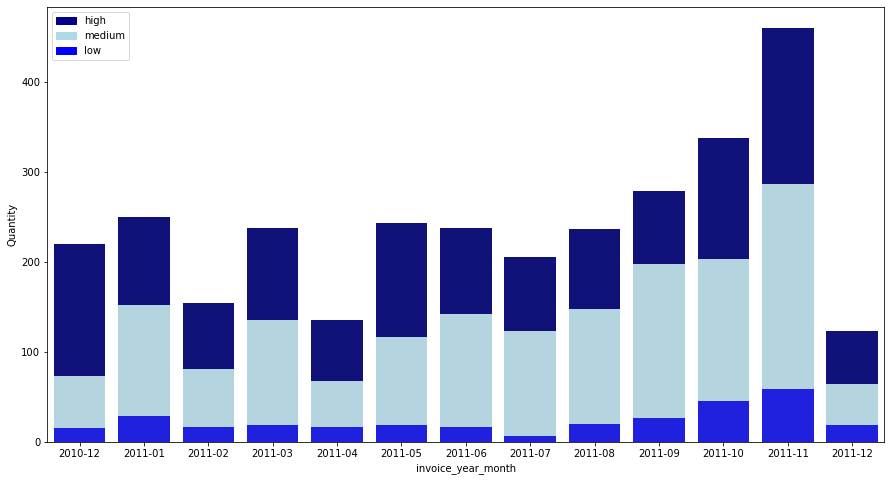

In [510]:
plt.figure(figsize = (15,8))

low_med_high = monthly_segment_quantity_top3.loc["POST"].reset_index().groupby("invoice_year_month")["Quantity"].sum().reset_index()
bar1 = sns.barplot(x = "invoice_year_month", y = "Quantity", data = low_med_high, color = "darkblue")

low_med = monthly_segment_quantity_top3.loc["POST"].loc[:, ["medium", "low"]].reset_index().groupby("invoice_year_month")["Quantity"].sum().reset_index()
bar2 = sns.barplot(x = "invoice_year_month", y = "Quantity", data = low_med, color = "lightblue")

low = monthly_segment_quantity_top3.loc["POST"].loc[:, "low"].reset_index().groupby("invoice_year_month")["Quantity"].sum().reset_index()
bar3 = sns.barplot(x = "invoice_year_month", y = "Quantity", data = low, color = "blue")

top_bar = mpatches.Patch(color='darkblue', label='high')
mid_bar = mpatches.Patch(color='lightblue', label='medium')
low_bar = mpatches.Patch(color='blue', label='low')
plt.legend(handles=[top_bar, mid_bar, low_bar])

Except for December 2011, POST shows a steady increase in order quantity. In the case of December 2011, since all data for December has not yet been collected, the quantity may appear low, so let's check this.

In [515]:
df_invoice_shipped.InvoiceDate.max()

Timestamp('2011-12-09 12:50:00')

Since the last invoice date in our data is shown as December 9, 2011, all of the data for December 11 has not yet been collected. Therefore, from the next item, let's proceed with the analysis excluding the data for Dec.

In POST, it can be seen that a lot of orders are placed in the medium and high groups, and few orders are placed in the low group. In addition, it can be seen that the order in the medium group is increasing especially as time goes by.

### 21916 : SET 12 RETRO WHITE CHALK STICKS

In [524]:
monthly_segment_quantity_top3.loc["21916"].drop("2011-12", axis = 0)

invoice_year_month  revenue_segment
2010-12             high                47
                    low                  5
                    medium              90
2011-01             high                48
                    low                 24
                                      ... 
2011-10             high               250
                    medium             112
2011-11             high                87
                    low                 28
                    medium              98
Name: Quantity, Length: 34, dtype: int64

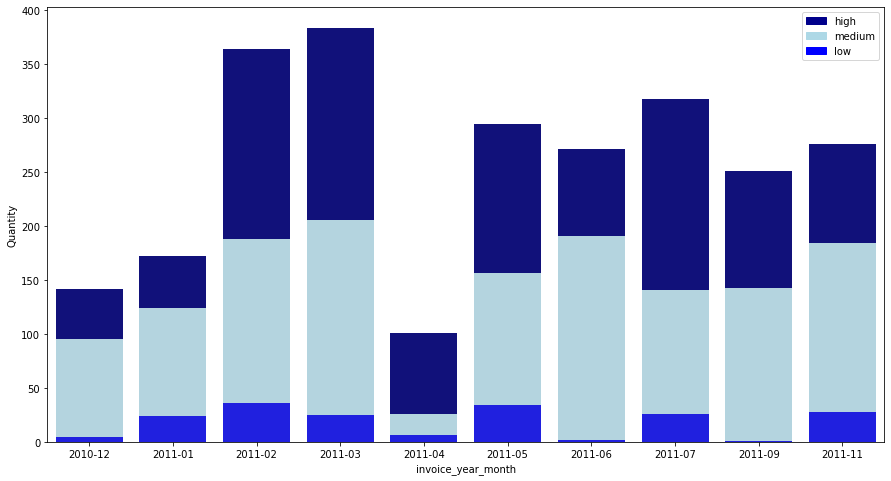

In [525]:
plt.figure(figsize = (15,8))

low_med_high = monthly_segment_quantity_top3.loc["21916"].drop("2011-12", axis = 0).reset_index().groupby("invoice_year_month")["Quantity"].sum().reset_index()
bar1 = sns.barplot(x = "invoice_year_month", y = "Quantity", data = low_med_high, color = "darkblue")

low_med = monthly_segment_quantity_top3.loc["21916"].drop("2011-12", axis = 0).loc[:, ["medium", "low"]].reset_index().groupby("invoice_year_month")["Quantity"].sum().reset_index()
bar2 = sns.barplot(x = "invoice_year_month", y = "Quantity", data = low_med, color = "lightblue")

low = monthly_segment_quantity_top3.loc["21916"].drop("2011-12", axis = 0).loc[:, "low"].reset_index().groupby("invoice_year_month")["Quantity"].sum().reset_index()
bar3 = sns.barplot(x = "invoice_year_month", y = "Quantity", data = low, color = "blue")

top_bar = mpatches.Patch(color='darkblue', label='high')
mid_bar = mpatches.Patch(color='lightblue', label='medium')
low_bar = mpatches.Patch(color='blue', label='low')
plt.legend(handles=[top_bar, mid_bar, low_bar])

Chalk sticks showed an increasing trend from December 2010 to March 2011 but decreased exceptionally only in April 2011, and then showed a steady transaction volume. Chalk sticks also order a lot from the high and medium groups, and the low group has fewer orders.

### 21914 : BLUE HARMONICA IN BOX

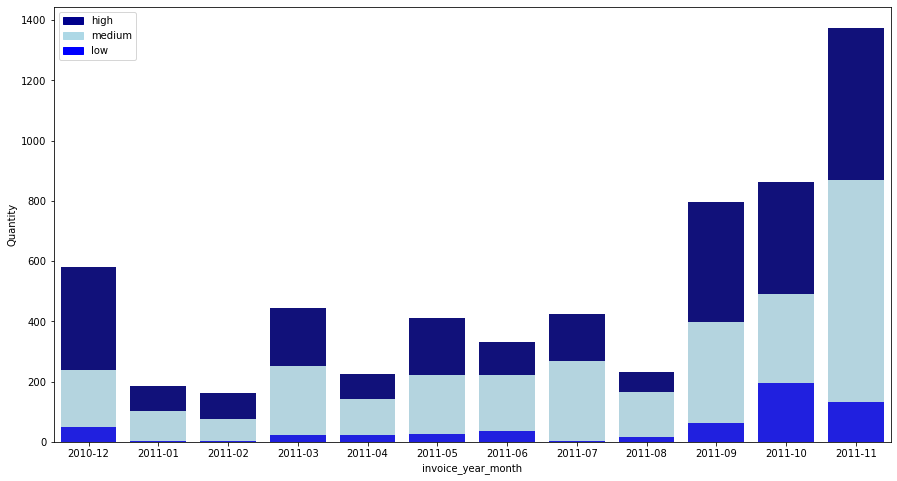

In [527]:
plt.figure(figsize = (15,8))

low_med_high = monthly_segment_quantity_top3.loc["21914"].drop("2011-12", axis = 0).reset_index().groupby("invoice_year_month")["Quantity"].sum().reset_index()
bar1 = sns.barplot(x = "invoice_year_month", y = "Quantity", data = low_med_high, color = "darkblue")

low_med = monthly_segment_quantity_top3.loc["21914"].drop("2011-12", axis = 0).loc[:, ["medium", "low"]].reset_index().groupby("invoice_year_month")["Quantity"].sum().reset_index()
bar2 = sns.barplot(x = "invoice_year_month", y = "Quantity", data = low_med, color = "lightblue")

low = monthly_segment_quantity_top3.loc["21914"].drop("2011-12", axis = 0).loc[:, "low"].reset_index().groupby("invoice_year_month")["Quantity"].sum().reset_index()
bar3 = sns.barplot(x = "invoice_year_month", y = "Quantity", data = low, color = "blue")

top_bar = mpatches.Patch(color='darkblue', label='high')
mid_bar = mpatches.Patch(color='lightblue', label='medium')
low_bar = mpatches.Patch(color='blue', label='low')
plt.legend(handles=[top_bar, mid_bar, low_bar])

Blue harmonica maintained its order quantity until August 2011 and then showed a sharp increase from September to November 2011. There was an increase in order quantity in all of the low, medium, and high groups.

# Please submit your completed notebook in .IPYNB and .HTML formats via Canvas